<a href="https://colab.research.google.com/github/He1laGR/MAI_predictive_analytics/blob/main/predective_analytics_lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Построить виртуальный датчик (ВД)


In [71]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [72]:
data = pd.read_csv('data_lec.csv', parse_dates=['timestamp'], index_col='timestamp')
target = pd.read_csv('target_lec.csv', parse_dates=['timestamp'], index_col='timestamp')

In [73]:
# Дополнительные признаки
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

In [74]:
# Интерполяция данных target на частоту данных telemetry
target = target.resample('min').interpolate(method='linear')

comb = data.join(target, how='inner', lsuffix='_data', rsuffix='_target').bfill().dropna()

# Создание лагов
for lag in range(1, 16):
  comb[f'target_lag_{lag}'] = comb['target_target'].shift(lag)

comb = comb.dropna()

# Масштабирование данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(comb)
comb = pd.DataFrame(scaled_data, columns=comb.columns, index=comb.index)

In [75]:
# Трейн тест сплит
train_size = int(len(comb) * 0.7)
val_size = int(len(comb) * 0.9)

train_data = comb.iloc[:train_size]
val_data = comb.iloc[train_size:val_size]
test_data = comb.iloc[val_size:]

print(f'Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}')

Train size: 12252, Val size: 3501, Test size: 1751


In [76]:
# Применяем RIDGE для учета выбросов
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, y_train = train_data.drop(columns=['target_target']), train_data['target_target']
X_val, y_val = val_data.drop(columns=['target_target']), val_data['target_target']

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Оценка на тренировочной выборке
y_pred_train = model_ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'RMSE на тренировочных данных: {rmse_train:.4f}')


RMSE на тренировочных данных: 0.0023


In [77]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Оценка на валидационной выборке
y_pred_val = model_ridge.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f'RMSE на валидационных данных: {rmse_val:.4f}')

RMSE на валидационных данных: 0.0042


In [78]:
X_test, y_test = test_data.drop(columns=['target_target']), test_data['target_target']

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred_test = model_ridge.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE на тестовых данных: {rmse_test:.4f}')


RMSE на тестовых данных: 0.0014


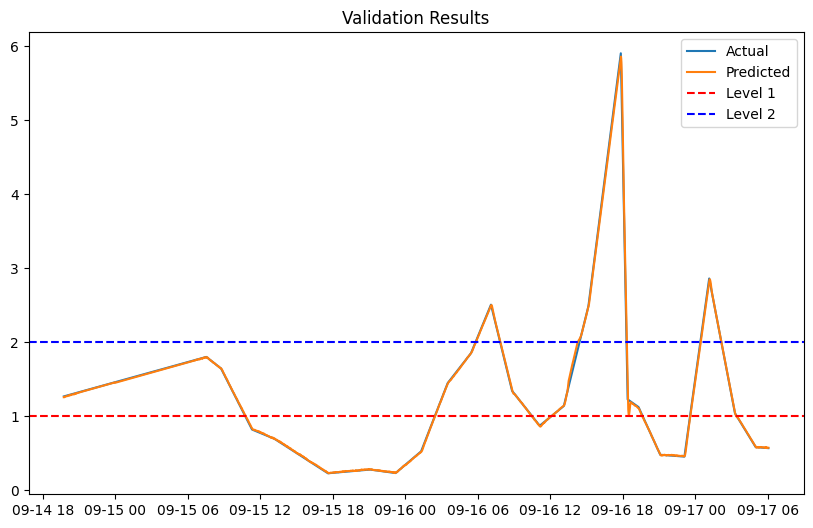

In [79]:
# Прогнозирование на валидационной выборке
y_pred_val = model_ridge.predict(X_val)

# Денормализация предсказаний и фактических значений
val_data_inv = scaler.inverse_transform(val_data)
y_val_inv = val_data_inv[:, comb.columns.get_loc('target_target')]
y_pred_val_inv = scaler.inverse_transform(
    np.hstack([X_val.values, y_pred_val.reshape(-1, 1)])
)[:, -1]

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val_inv, label='Actual')
plt.plot(y_val.index, y_pred_val_inv, label='Predicted')
plt.axhline(y=1, color='r', linestyle='--', label='Level 1')
plt.axhline(y=2, color='b', linestyle='--', label='Level 2')
plt.legend()
plt.title('Validation Results')
plt.show()

Модель Ridge отлично справляяется с этой задачей

Пример работы

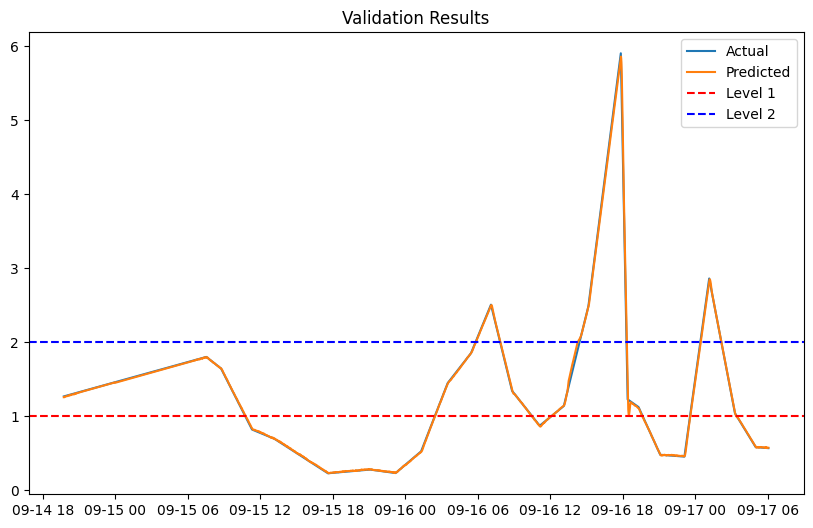

In [83]:
# Прогнозирование на валидационной выборке
y_pred_val = model_ridge.predict(X_val)

# Денормализация предсказаний и фактических значений
val_data_inv = scaler.inverse_transform(val_data)
y_val_inv = val_data_inv[:, comb.columns.get_loc('target_target')]
y_pred_val_inv = scaler.inverse_transform(
    np.hstack([X_val.values, y_pred_val.reshape(-1, 1)])
)[:, -1]

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val_inv, label='Actual')
plt.plot(y_val.index, y_pred_val_inv, label='Predicted')
plt.axhline(y=1, color='r', linestyle='--', label='Level 1')
plt.axhline(y=2, color='b', linestyle='--', label='Level 2')
plt.legend()
plt.title('Validation Results')
plt.show()

# Логика для виртуального датчика
for idx, pred in enumerate(y_pred_val_inv):
    if pred < 1:
        print(f"Warning: Value dropped below 1 at index {y_val.index[idx]}")
    elif pred > 2:
        print(f"Warning: Value exceeded 2 at index {y_val.index[idx]}")


## 2. Построить прогнозную модель, которая на горизонте в 15 минут может установить значение таргета.

In [100]:
# Создание таргета с сдвигом на 15 минут вперед
comb['target_15min'] = comb['target_target'].shift(-15)  # Сдвигаем таргет на 15 шагов

# Разделение данных на тренировочную, валидационную и тестовую выборки
train_size = int(len(comb) * 0.7)
val_size = int(len(comb) * 0.9)

train_data = comb.iloc[:train_size]
val_data = comb.iloc[train_size:val_size]
test_data = comb.iloc[val_size:]

# Удаляем строки с пропусками, так как теперь у нас таргет через 15 минут
train_data = train_data.dropna(subset=['target_15min'])
val_data = val_data.dropna(subset=['target_15min'])
test_data = test_data.dropna(subset=['target_15min'])

X_train, y_train = train_data.drop(columns=['target_target', 'target_15min']), train_data['target_15min']
X_val, y_val = val_data.drop(columns=['target_target', 'target_15min']), val_data['target_15min']
X_test, y_test = test_data.drop(columns=['target_target', 'target_15min']), test_data['target_15min']


In [101]:
# Обучение модели Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Прогнозирование на тренировочной выборке
y_pred_train = model_ridge.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'RMSE на тренировочных данных: {rmse_train:.4f}')


RMSE на тренировочных данных: 0.0137


In [102]:
# Прогнозирование на валидационной выборке
y_pred_val = model_ridge.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f'RMSE на валидационных данных: {rmse_val:.4f}')


RMSE на валидационных данных: 0.0253


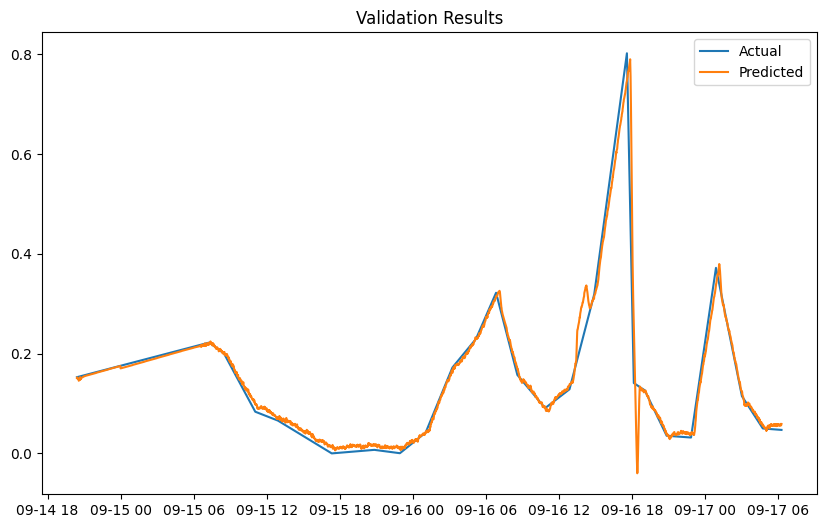

In [103]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred_val, label='Predicted')
plt.legend()
plt.title('Validation Results')
plt.show()


 ## 3*. Построить модель, которая может определить значение таргета в случае изменения показателя gas_consumption1 на шаг 150 (текущее значение + 150) в последующие 15 минут.

RMSE на валидационных данных: 0.0253


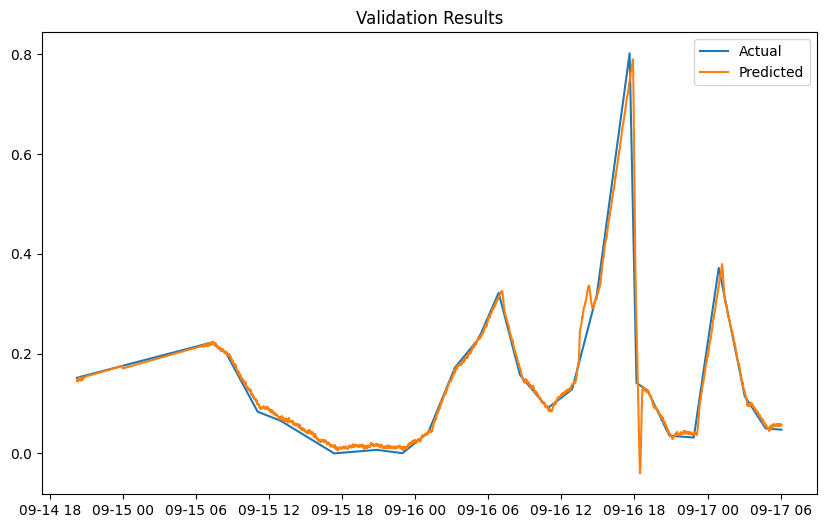

RMSE на тестовых данных: 0.0086


In [106]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('data_lec.csv', parse_dates=['timestamp'], index_col='timestamp')
target = pd.read_csv('target_lec.csv', parse_dates=['timestamp'], index_col='timestamp')

# Дополнительные признаки
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Интерполяция данных target на частоту данных telemetry
target = target.resample('min').interpolate(method='linear')

# Объединяем данные
comb = data.join(target, how='inner', lsuffix='_data', rsuffix='_target').bfill().dropna()

# Создание лагов
for lag in range(1, 16):
    comb[f'target_lag_{lag}'] = comb['target_target'].shift(lag)

# Сдвигаем gas_consumption1 на 150 шагов для предсказания через 150 минут
comb['gas_consumption1_lag_150'] = comb['gas_consumption1'].shift(150)

# Добавляем целевой признак для предсказания через 15 минут
comb['target_15min'] = comb['target_target'].shift(-15)

# Убираем строки с пропусками (так как они могут появиться из-за сдвигов)
comb = comb.dropna()

# Масштабирование данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(comb)
comb = pd.DataFrame(scaled_data, columns=comb.columns, index=comb.index)

# Разделение данных на обучающую, валидационную и тестовую выборки
train_size = int(len(comb) * 0.7)
val_size = int(len(comb) * 0.9)

train_data = comb.iloc[:train_size]
val_data = comb.iloc[train_size:val_size]
test_data = comb.iloc[val_size:]

# Признаки и целевая переменная
X_train, y_train = train_data.drop(columns=['target_target', 'target_15min']), train_data['target_15min']
X_val, y_val = val_data.drop(columns=['target_target', 'target_15min']), val_data['target_15min']
X_test, y_test = test_data.drop(columns=['target_target', 'target_15min']), test_data['target_15min']

# Обучение модели Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Прогнозирование на валидационной выборке
y_pred_val = model_ridge.predict(X_val)

# Оценка качества модели на валидационных данных
rmse_val = root_mean_squared_error(y_val, y_pred_val)
print(f'RMSE на валидационных данных: {rmse_val:.4f}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, y_pred_val, label='Predicted')
plt.legend()
plt.title('Validation Results')
plt.show()

# Прогнозирование на тестовой выборке
y_pred_test = model_ridge.predict(X_test)

# Оценка качества модели на тестовых данных
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'RMSE на тестовых данных: {rmse_test:.4f}')
